# TalTech'i programmeerimise ainete Discordi tekstide analüüs

Kasutatud meetodid:
- API requestide abil kanalite sisu hamkimine
- Andmete eeltöötlemine (algtüve võtmine, sõnade filtreerimine)
- Meelsusanalüüs
- TODO: Kvantitatiivsed mõõdikud (loetavus, ametlikkus ja informatiivsus)
- Võtmesõnade ekstrahheerimine
- Tekstikokkuvõtete genereerimine
- TODO: Võtmesõnade ning sisukokkuvõtete klasterdamine 

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
from concat_configuration import ConcatConfiguration
from count_configuration import CountConfiguration
from textrank_analyzer import TextRankAnalyzer
from quantitative_metrics import QuantitativeMetrics
from cached_runner import CachedRunner
from IPython.display import display
import pandas as pd

In [3]:
%%capture
count_configuration = CountConfiguration()
count_runner = CachedRunner(count_configuration)
count_matrixes = count_runner.get_datasets(fresh=False)

count_all = count_matrixes[0]
count_group_year = count_matrixes[1]
count_year_channels = count_matrixes[2]
count_flat = count_matrixes[3]
count_group_category = count_matrixes[4]

In [70]:
count_all = count_all.sort_values(by='group')
count_group_year = count_group_year.sort_values(by='group')
count_year_channels = count_year_channels.sort_values(by='group')
count_flat = count_flat.sort_values(by='group')
count_group_category = count_group_category.sort_values(by='group')
display(count_all)

,group,group_members,total_words,in_a_row,count_0,repetitions_0,count_1,repetitions_1,count_2,repetitions_2,count_3,repetitions_3,count_4,repetitions_4,count_5,repetitions_5,count_6,repetitions_6,count_7,repetitions_7,count_8,repetitions_8,count_9,repetitions_9,valence_only_negative,valence_mostly_negative,valence_only_neutral,valence_mostly_neutral,valence_only_mixed,valence_mostly_mixed,valence_only_positive,valence_mostly_positive
0,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,1,olema,144647,mina,80840,saama,37371,tegema,26555,pidama,20946,tulema,12925,minema,12117,võima,10649,panema,9018,teadma,8998,1625447,29681,746658,38954,0,125232,587919,20364
1,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,2,mina olema,11448,mina saama,2282,saama aru,2257,pidama olema,2110,olema mina,1975,mina tegema,1845,olema hea,1751,sebastian sõeruer,1536,mina pidama,1528,mina arvama,1453,1625447,29681,746658,38954,0,125232,587919,20364
2,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,3,mina saama aru,346,eelmine aasta olema,93,mina aru saama,82,saama mina kood,76,list index out,68,mina olema tunne,65,olema hea mõte,63,olema õrn aim,62,mina olema küsimus,59,mina kood vaatama,57,1625447,29681,746658,38954,0,125232,587919,20364
3,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,4,check the file name,45,inval litera for int,32,saama mina kood vaatama,31,blacklargesquare |||| blacklargesquare ||||,25,|||| blacklargesquare |||| blacklargesquare,25,mina olema õrn aim,22,saama vaatama mina kood,21,testing faile with message,19,require between summary line,17,line require between summary,17,1625447,29681,746658,38954,0,125232,587919,20364


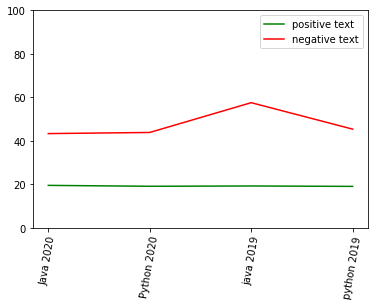

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_axis_for_emotion(emotion, df):
    groups = set()
    x = []
    y = []
    for index, row in df.iterrows():
        if row["group"] not in groups:
            groups.add(row["group"])
            y.append(100 * (row["valence_only_" + emotion] + row["valence_mostly_" + emotion]) / max(1, row["total_words"]))
            x.append(row["group"])
    return x, y

x1, y1 = get_axis_for_emotion("positive", count_group_year)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_year)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=10,10

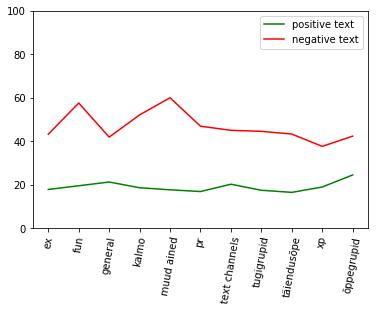

In [72]:
%matplotlib inline
x1, y1 = get_axis_for_emotion("positive", count_group_category)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_category)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=10,10

<IPython.core.display.Javascript object>


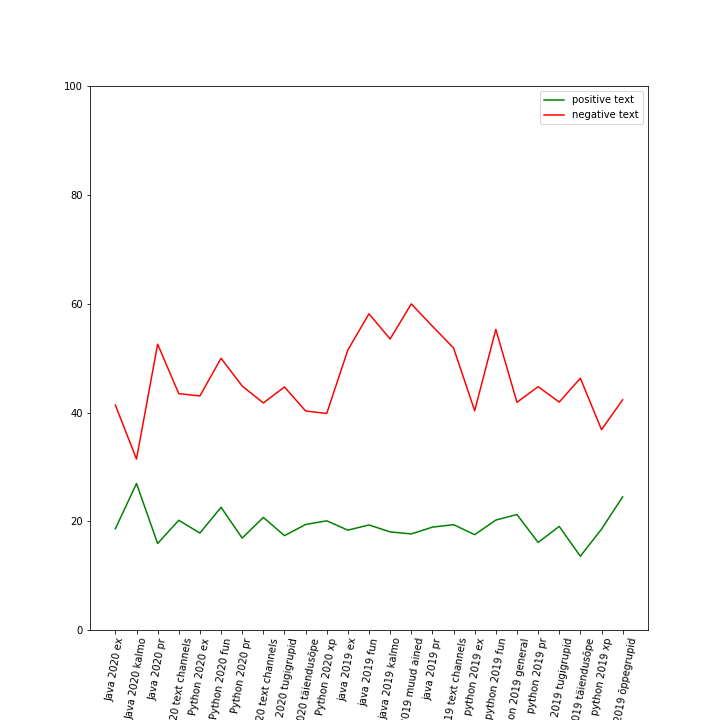

In [81]:
%matplotlib notebook
x1, y1 = get_axis_for_emotion("positive", count_year_channels)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_year_channels)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=10,10

In [5]:
count_matrixes_with_context = count_runner.get_datasets(fresh=False, filter_function=count_configuration.all_words_have_context)

context_count_all = count_matrixes_with_context[0]
context_count_group_year = count_matrixes_with_context[1]
context_count_year_channels = count_matrixes_with_context[2]
context_count_flat = count_matrixes_with_context[3]
context_count_group_category = count_matrixes_with_context[4]

In [6]:
%%capture
concat_configuration = ConcatConfiguration()
concat_runner = CachedRunner(concat_configuration)
concat_matrixes = concat_runner.get_datasets(fresh=False)

concat_all = concat_matrixes[0]
concat_year = concat_matrixes[1]
concat_year_channels = concat_matrixes[2]
concat_flat = concat_matrixes[3]
concat_group_category = concat_matrixes[4]

In [103]:
quantitative_metrics_table = QuantitativeMetrics().analyze(concat_year_channels)

In [104]:
display(quantitative_metrics_table)

,group,fres,gunning_fog,lexical_density,formality
0,Python 2020 fun,57.83,14.71,38.52,39.45
1,Java 2020 pr,54.67,14.75,40.27,40.14
2,java 2019 text channels,63.71,11.77,38.72,33.71
3,java 2019 fun,62.41,11.24,40.58,35.61
4,python 2019 general,55.88,14.02,41.48,37.45
5,Java 2020 kalmo,49.30,15.90,42.90,40.87
6,python 2019 täiendusõpe,61.43,12.71,38.84,38.40
7,python 2019 pr,57.88,13.65,40.16,40.93
8,python 2019 xp,58.34,13.81,39.03,39.20
9,java 2019 pr,62.16,12.63,39.08,35.79


In [105]:
import numpy as np
import itertools

matrix = [
    ("FRES", quantitative_metrics_table["fres"]),
    ("GFOG", quantitative_metrics_table["gunning_fog"]),
    ("Density", quantitative_metrics_table["lexical_density"]),
    ("Formality", quantitative_metrics_table["formality"])
]

print("Correlations between:")
for (name1, list1), (name2, list2) in itertools.product(matrix, repeat = 2):
    print(name1 + " and " + name2 + " are " + str(abs(round(np.corrcoef(list1, list2)[0, 1], 2))))

Correlations between:
FRES and FRES are 1.0
FRES and GFOG are 0.89
FRES and Density are 0.71
FRES and Formality are 0.59
GFOG and FRES are 0.89
GFOG and GFOG are 1.0
GFOG and Density are 0.55
GFOG and Formality are 0.67
Density and FRES are 0.71
Density and GFOG are 0.55
Density and Density are 1.0
Density and Formality are 0.3
Formality and FRES are 0.59
Formality and GFOG are 0.67
Formality and Density are 0.3
Formality and Formality are 1.0


In [7]:
textrank_table = TextRankAnalyzer().analyze(concat_flat)

In [8]:
pd.set_option('display.max_colwidth', -1)
display(textrank_table)
pd.reset_option('display.max_colwidth')

,group,group_members,summary,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10,keyword_11,keyword_12,keyword_13,keyword_14,keyword_15,keyword_16,keyword_17,keyword_18,keyword_19
0,TUGIGRUPID / lilia-tugigrupp,['TUGIGRUPID / lilia-tugigrupp'],"Единственный ответ, что мне пришёл на ум это то, что я хотел бы заниматься чем - то, что связано с компьютерами, инженером становиться как - то не очень хотелось, вот и решил пойти программистом.\n@justanother.day я вот только-только сделала, спасибо 🙂 @lilia Аго про это писал, что это возникает из-за того, что не все книги попадают в нужные категории, можешь чекнуть и сказать в чём проблема?",меня,если,очень,было,поэтому,тоже,надо,вообще,есть,просто,люблю,тогда,пишите,сейчас,играю,вопрос,могу,время,чтобы,
1,Text Channels / videod,['Text Channels / videod'],"ex01 vihjed: https://www.youtube.com/watch?v=tpnP77NobzQ.\npr03/ex03 lahendamine: https://www.youtube.com/watch?v=30kLIGVcU8w.\nex04 vihjed: https://www.youtube.com/watch?v=-BBWwJzaYnk. elementide järjesatmine (sortimine): https://youtu.be/HwXuPoQLcS4.\nex08 vihjed: https://www.youtube.com/watch?v=sa5hQaNaCQ0 ex08 vihjevideo on suhteliselt pikk.\nVideo on suuresti lõikamata, aga proovisin mõned kohad ajaliselt ära annoteerida) ex12 vihjevideo: https://www.youtube.com/watch?v=OEEScyJa7Ls\npr13 vihjed (peamiselt võtmete jms tegemine): https://youtu.be/zJuT8j0rjGg. ex13 vihjed: https://www.youtube.com/watch?v=sAmEoCGcwXs. ex13 veel: https://www.youtube.com/watch?v=Aia_jZaM-kw.",watch,https,teema video,ex vihje,pr väike,ülesanne,i,näidislahendus,kood,r,python,j,tsükkel,,,,,,,
2,xp / xp04_maze,['xp / xp04_maze'],"mina ei tea kas nii moodi on võimalik teha, aga kas keegi teine saaks mulle öelda kui palju nad saavad funktsiooniga solve() selle mazi tehes.\nMul testid failivad, aga ise teste tehes ei leia üles, milline maze vale tulemuse võib anda.\nAssertionError: _test_all_the_paths(maze) Kas testeriga on praegu mingi probleem?",test,maze,ülesanne,väike,suht,cost,kord viga sein,vihje,tester,python,mina võimalik,õige,küsimus,locate,koht,mapp,koordinaat,,,
3,PR / pr08-steakhouse,['PR / pr08-steakhouse'],"🤔 refreshi võib-olla, mul hakkas tööle.\njava.lang.AssertionError: expected [Boriss] but found [Henry] kui keegi saab millalgi aega vaadata, milles probleem on.\n```Teiste steikide puhul vali järjekorrast esimene kokk``` Kas tester ei tööta või on mul endal mingi jama?\nKas see polnud mitte selline, et kui pikkus on paaris, siis null, muidu pikkus?",pikkus,tester,found,java,suvaline arvutus vastus õige,kiri kord refreshi,appreciate krkoit steik vali,pilk uniiid eepuu,jjaaks artur,,,,,,,,,,,
4,Text Channels / projekt,['Text Channels / projekt'],"Mul on paar ainet, mille kohta ma olen mitu aastat mõelnud, et teen ära, aga siis pärast esimest tundi võtan deklaratsioonist ära 😄 (mõni abiõppejõud võib rääkida tarkvara tehnikast 😛 ) Kui ma kunagi way back when keemiat õppisin, siis oli ka üks aine, kus oli nii, et läksime esimesse tundi, kuulasime seal 4h, mitte keegi ei saanud aru, mis seal aines toimub, kuidas hinnet saab, mida tegema peab, mis materjalid olemas on ja mis üldse selle aine teema on 😄 Aga on ka selliseid, kus on näha, et õppejõudu ei huvita ja ta ei viitsi väga.",mäng,projekt,issue,issuet,server,https,gitlab tiim,java,punkt,sprint,com,commit,probleem,aine,fail,gradle,idee,idea,gitlabi,inimene
5,xp / xp07_stargate,['xp / xp07_stargate'],"Ma igaks juhuks mainin, et neid vahearuannetega teste veel ei ole (basic ja advanced puhul ei pea vahearuandeid tegema) Aga nende puhul on idee selles, et alguses on teada, mis päevadel vahearuanne tuleb teha ning kui sa tead, et nt 10 päeva pärast on vahearuanne vaja teha, siis sa ei tohi hakata koloniseerima planeeti, mille koloniseerimine võtab 15 päeva aega.",planeet,strateegia,ülesanne nädal võistlus,küsimus,test,viga kood tester,päev,stargate,osaleja,parameeter,eksam,vaheraport,jaanuar,mäng,punkt,juht,,,,
6,Text Channels / teadaanded